In [1]:
import sys
sys.path.append("../..")

#Defining libraries
import os
import math
from datetime import date, timedelta
import pandas as pd
import xarray as xr
import plotly.graph_objects as go
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import box
from scipy.interpolate import griddata, interpn
import datacube
from copy import deepcopy
import statsmodels.api as sm

import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
import rioxarray as rxr
import pickle

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.neural_network import MLPClassifier

from modules import processing_module as processing
from modules import ai_module as ai

2025-02-14 21:49:34.124268: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-14 21:49:34.125485: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-14 21:49:34.147110: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-14 21:49:34.147579: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-14 21:49:34.537299: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

In [2]:
'''
1-11-> Residential urban areas 
2-121,13->Industrial and abbandoned urban areas
3-122,123,124 Transportation infrastructure (streets, highways, airports, and ports)
4-14->Urban green areas
5-2->Agricultural areas
6-3->Forest
7-4/5->Hydro and humid bodies
'''
#Convert from copernicus code 2018 to an internal code
URBAN = 1
INDUSTRIAL = 2
TRANSPORTATION = 3
URBAN_VEGETATION = 4
RURAL = 5
FOREST = 6
WATER = 7
LC_NO_DATA = 9999

    
# Function to check if the file is a tiff and must be read.
def check_wrong_files(f):
    if f == 'clip': return True #avoid entering the "clip" folder
    if 'ipynb' in f: return True #avoid entering the "ipynb_checkpoint" file
    if 'tar' in f: return True #avoid entering "tar" files
    if 'aux' in f: return True #avoid entering "aux" files
    return False

In [3]:
def fetch_from_odc(odc_datasets, samples, x=None, y=None):
    odc_df = None
    for df_name in odc_datasets:
        print(f"Sampling {df_name}")
        #odc datasets to be merged
        odc_product = df_name

        datasets = dc.find_datasets(product=odc_product)
        cf_data = dc.load(datasets=datasets)
        if x is not None and y is not None:
            cf_sel = cf_data.squeeze().sel(
                y=y, 
                x=x, 
                method='nearest'
            )
        else:
            cf_sel = cf_data.squeeze()

        cf_var_name = list(cf_data.data_vars.keys())[0]
        cf_df = cf_sel.to_dataframe()
        del cf_sel
        
        cf_df.rename(columns={cf_var_name:odc_product},inplace=True)
        cf_df.drop(['time','spatial_ref'],axis=1,inplace=True)
        if 'x' in list(cf_df.columns): cf_df.drop(['x'],axis=1,inplace=True)
        if 'y' in list(cf_df.columns): cf_df.drop(['y'],axis=1,inplace=True)

        del cf_data
        
        if odc_df is None:
            odc_df = cf_df.copy()
            print(len(samples), len(odc_df))
            odc_df = pd.concat([samples, odc_df], axis=1)
        else:
            odc_df = pd.concat([odc_df, cf_df[odc_product].astype('float32')], axis=1)

    odc_df = odc_df.dropna()

    print('odc_df Ready!')
    return odc_df


In [4]:
city = "MILANO"
city_epsg = 32632
data_folder = "data"
landcover_path = f"{data_folder}/landcover/DUSAF_2021_MCM_mapped.tif"
encode = True
normalize = True
train_model = True
model = 'ANN'

In [5]:
#Example of datacube config file:
#datacube_config_path = "/home/user/datacube.conf"

datacube_config_path = "/home/user/datacube.conf"
dc = datacube.Datacube(app = "my_app", config = datacube_config_path)
products = dc.list_products()
for p in products.name.values:
    print(p)

accelerazione_suolo
aspect
building_height
corine_urban_atlas_milan
densita_popolazione
dtm_milan
dusaf
dusaf15
dusaf99
fattori_amplificazione
flood_extent
flood_extent_year
geologia
hillshade
ixelles_dem
ixelles_distance_to_roads
ixelles_distance_to_tracks
ixelles_distance_to_water
ixelles_imperviousness
ixelles_landcover
ixelles_population
ixelles_slope
litologia_superficiale
main_road_distance
metropolitana
ndvi_2000
ndvi_2002
ndvi_2014
ndvi_2019
piezometrie_profondo
piezometrie_superficiale
piraeus_building_height
piraeus_dem
piraeus_distance_to_roads
piraeus_distance_to_tracks
piraeus_imperviousness
piraeus_landcover
piraeus_landcover_for_uhi
piraeus_population
piraeus_slope
plan_curvature
profile_curvature
reticolo_idrografico
river_distance
sabbie_falda
slope
sofia_building_height
sofia_dem
sofia_distance_to_road
sofia_distance_to_train_tracks
sofia_distance_to_water
sofia_imperviousness
sofia_landcover
sofia_population
sofia_slope
soggiacenza_falda
spi
strade_ferrovie
temperatu

/home/user/anaconda3/envs/odc_env/lib/python3.8/site-packages/datacube/drivers/driver_cache.py:54: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import iter_entry_points


In [6]:
#The datasets from the ODC from which data is sampled
odc_datasets = [
    'building_height', 'densita_popolazione',
    'main_road_distance', 'river_distance', 
    'water_distance'
]

In [7]:
importer = processing.HarmoniaProcessor()

# get raster parameters
with rasterio.open(landcover_path, driver="GTiff") as base_raster:
    transform = base_raster.transform
    init_x = transform[2]
    init_y = transform[5]
    step_x = transform[0]
    step_y = transform[4]

#import samples
base_path = f'training_samples'
sufix = '_feb_14_100mil'
samples_path = f'{base_path}/{city}_samples{sufix}.csv'
samples = importer.import_df(samples_path, date_format=None)

samples['x'] = samples['x'].apply(
    lambda x: init_x + (x * step_x)
)
samples['y'] = samples['y'].apply(
    lambda y: init_y + (y * step_y)
)
samples


x            y  landcover  uhi      ndvi      ndbi  \
0        519176.1148  5020180.992          3    0  0.545373 -0.191074   
1        526046.1148  5040635.992          1    0  0.532477 -0.050983   
2        500691.1148  5045605.992          2    0  0.029006 -0.023896   
3        509236.1148  5045100.992          1    0  0.820186 -0.345854   
4        517936.1148  5026160.992          2    0  0.803168 -0.224469   
...              ...          ...        ...  ...       ...       ...   
1699995  491126.1148  5028950.992          5    1  0.718751 -0.247142   
1699996  531781.1148  5046760.992          5    1  0.673632 -0.237655   
1699997  533031.1148  5045590.992          5    1  0.678845 -0.183864   
1699998  536296.1148  5044810.992          5    1  0.601732 -0.156362   
1699999  488696.1148  5040730.992          5    1  0.530526 -0.082139   

           albedo        lst    raster  
0        0.133395  308.26605  20180815  
1        0.158311  308.89840  20180815  
2        0.328141  308.29340  20180815  
3        0.124499  308.54633  20180815  
4        0.178254  307.58588  20180815  
...           ...        ...       ...  
1699995  0.158714  309.05905  20200719  
1699996  0.190506  309.10350  20200719  
1699997  0.169460  308.88815  20200719  
1699998  0.168661  309.00095  20200719  
1699999  0.187548  309.09665  20200719  

[1700000 rows x 9 columns]

In [11]:
samples.describe()

x             y     landcover        uhi          ndvi  \
count  1.700000e+06  1.700000e+06  1.700000e+06  1700000.0  1.700000e+06   
mean   5.115036e+05  5.034707e+06  3.359465e+00        0.5  5.634646e-01   
std    1.646079e+04  9.455027e+03  1.777479e+00        0.5  1.888875e-01   
min    4.770611e+05  5.001001e+06  1.000000e+00        0.0 -7.005625e+00   
25%    4.975811e+05  5.028271e+06  2.000000e+00        0.0  4.276208e-01   
50%    5.111011e+05  5.035926e+06  3.500000e+00        0.5  5.811842e-01   
75%    5.254561e+05  5.041931e+06  5.000000e+00        1.0  7.155375e-01   
max    5.430461e+05  5.054296e+06  6.000000e+00        1.0  1.712819e+01   

               ndbi        albedo           lst        raster  
count  1.700000e+06  1.700000e+06  1.700000e+06  1.700000e+06  
mean  -1.729076e-01  1.551307e-01  3.113869e+02  2.018662e+07  
std    1.486488e-01  3.699101e-02  5.339333e+00  2.499394e+04  
min   -9.712793e-01 -8.028007e-02  2.936916e+02  2.015071e+07  
25%   -2.826000e-01  1.375507e-01  3.094658e+02  2.016082e+07  
50%   -1.662355e-01  1.544830e-01  3.111919e+02  2.019072e+07  
75%   -6.203534e-02  1.712040e-01  3.140528e+02  2.021071e+07  
max    1.658523e+00  1.511207e+00  3.228097e+02  2.022081e+07

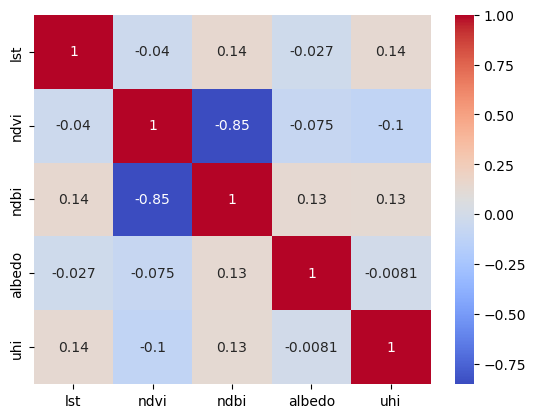

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

corr = samples[["lst", "ndvi", "ndbi", "albedo", "uhi"]].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.show()


In [14]:
corr

lst      ndvi      ndbi    albedo       uhi
lst     1.000000 -0.040293  0.144669 -0.026664  0.137736
ndvi   -0.040293  1.000000 -0.853500 -0.074702 -0.103615
ndbi    0.144669 -0.853500  1.000000  0.131871  0.125041
albedo -0.026664 -0.074702  0.131871  1.000000 -0.008131
uhi     0.137736 -0.103615  0.125041 -0.008131  1.000000

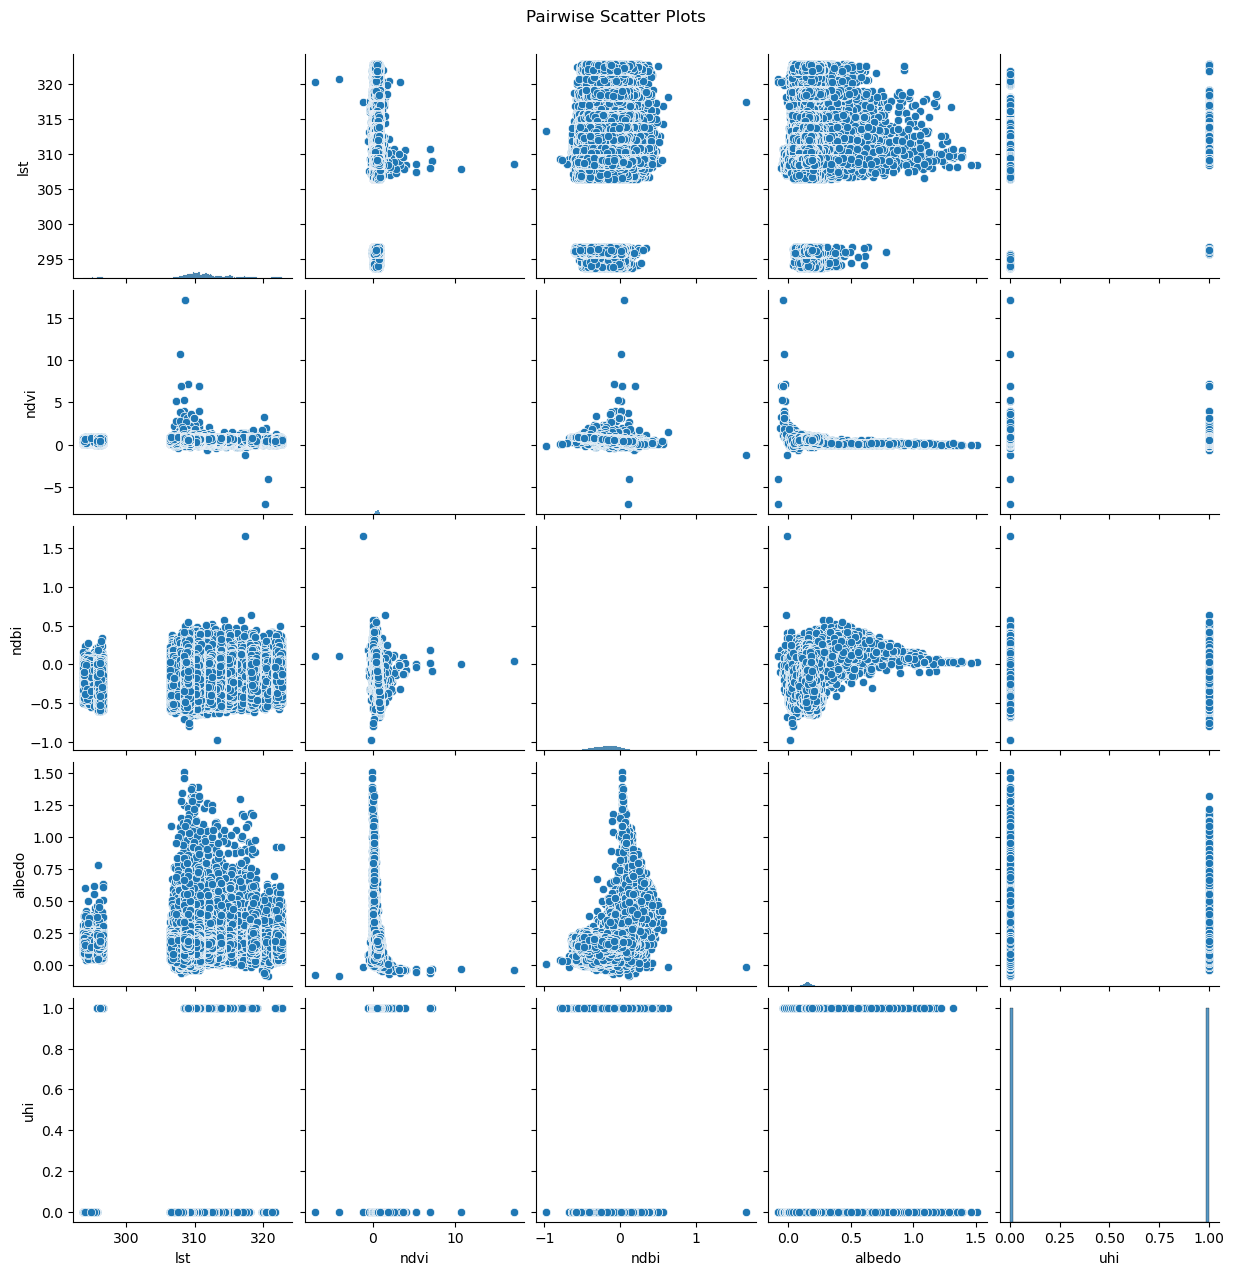

In [15]:
sns.pairplot(samples[['lst', 'ndvi', 'ndbi', 'albedo', 'uhi']])
plt.suptitle('Pairwise Scatter Plots', y=1.02)
plt.show()

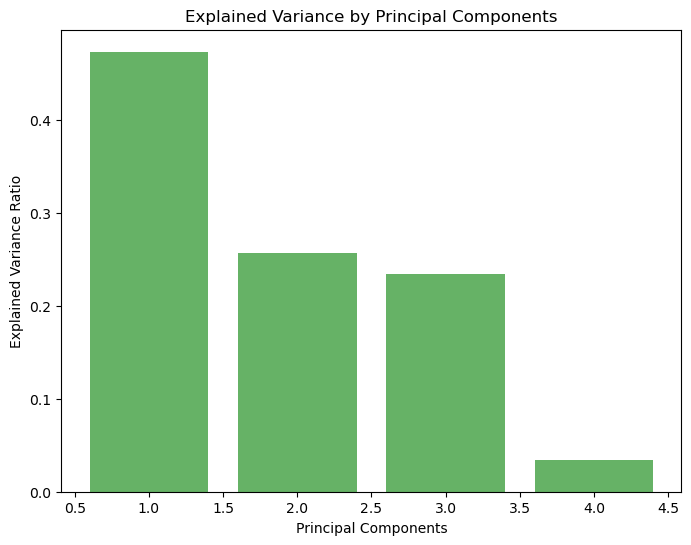

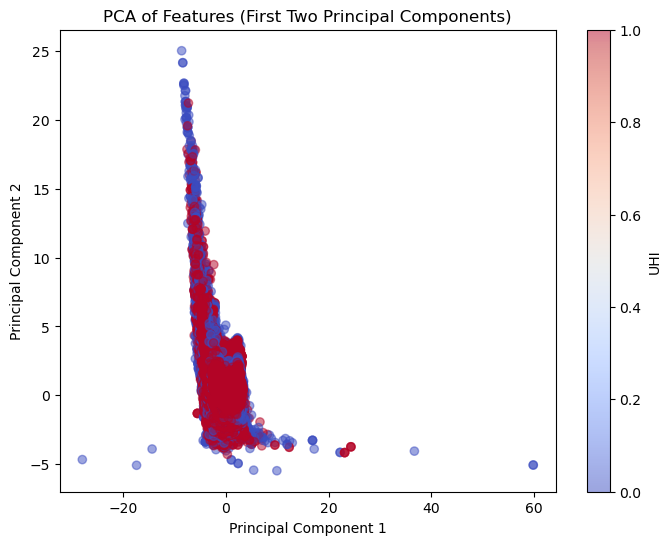

PCA Component Loadings (Contributions of Features to Components):
             PC1       PC2       PC3       PC4
lst    -0.138985 -0.741693  0.650197 -0.088422
ndvi    0.684794 -0.021462  0.216484  0.695508
ndbi   -0.698183 -0.022939 -0.078689  0.711212
albedo -0.155825  0.670003  0.724008 -0.051256


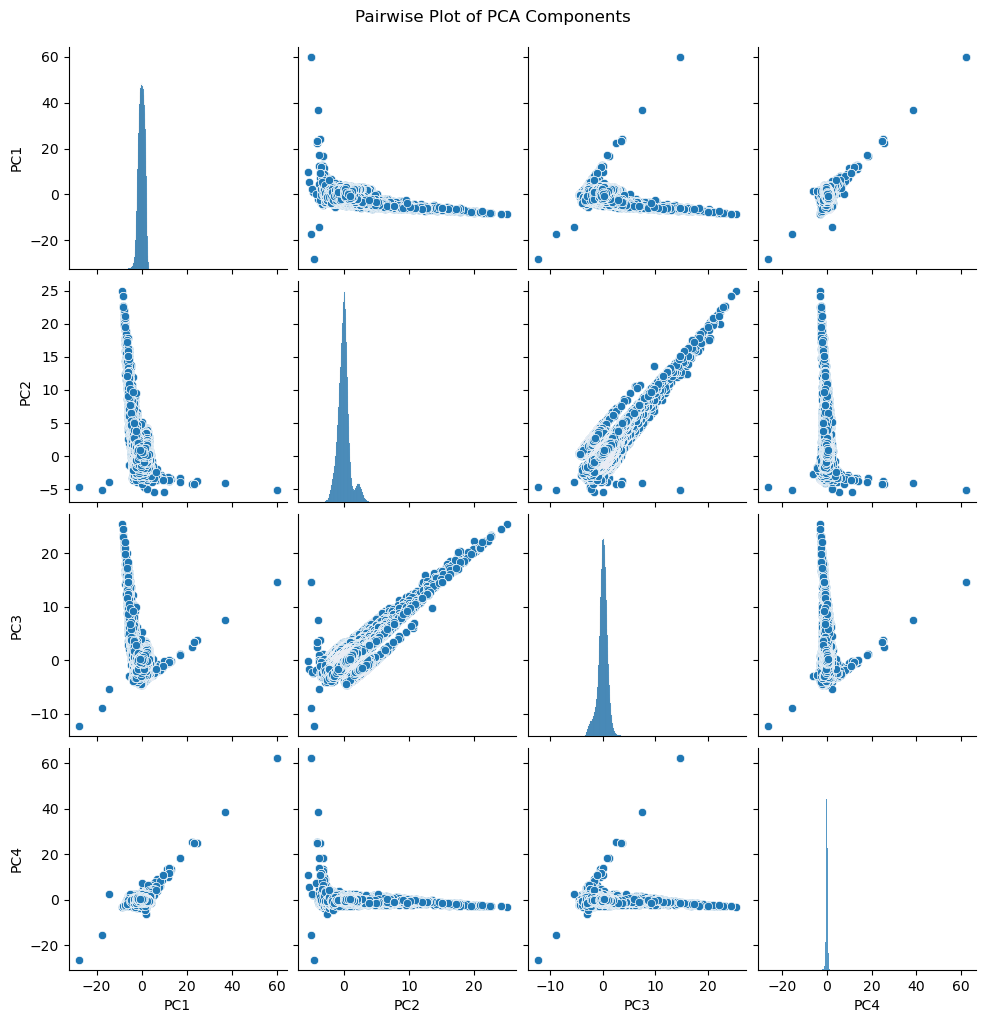

In [17]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'samples' is the DataFrame with your data

# 1. Select the features for PCA (excluding 'uhi' if it's a target)
features = ['lst', 'ndvi', 'ndbi', 'albedo']  # You can adjust this list

# 2. Standardize the features
X = samples[features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. Run PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# 4. Explained variance ratio (to see how much each component explains the variance)
explained_variance = pca.explained_variance_ratio_

# Plot explained variance ratio for each component
plt.figure(figsize=(8, 6))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.6, color='g')
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance by Principal Components')
plt.show()

# 5. Plot the first two principal components
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=samples['uhi'], cmap='coolwarm', alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Features (First Two Principal Components)')
plt.colorbar(label='UHI')
plt.show()

# 6. Display the PCA component loadings (contributions of each feature)
loadings = pca.components_.T  # Transpose to match features to components
loading_df = pd.DataFrame(loadings, columns=[f'PC{i+1}' for i in range(len(features))], index=features)

# Print the loadings DataFrame (it shows how much each feature contributes to each PC)
print("PCA Component Loadings (Contributions of Features to Components):")
print(loading_df)

# 7. You can also plot all the components in a pairplot if you want to visualize correlations
pca_df = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(len(features))])
sns.pairplot(pca_df)
plt.suptitle('Pairwise Plot of PCA Components', y=1.02)
plt.show()


In [18]:
single_positions = samples.drop_duplicates(subset=['x', 'y']).reset_index(drop=True)[['x','y']]
single_x_positions = single_positions.x.values
single_y_positions = single_positions.y.values

odc_df = fetch_from_odc(
    odc_datasets, 
    samples,
    x=xr.DataArray(single_x_positions, dims=['index']),
    y=xr.DataArray(single_y_positions, dims=['index'])
)

# set UHI column as integer
odc_df['uhi'] = odc_df['uhi'].apply(
    lambda x: int(x),
).astype('int8')

#coordinates as float32 to reduce size in disk
odc_df['x'] = odc_df['x'].astype('float64')
odc_df['y'] = odc_df['y'].astype('float64')
odc_df['lst'] = odc_df['lst'].astype('float32')
odc_df['ndvi'] = odc_df['ndvi'].astype('float32')
odc_df['albedo'] = odc_df['albedo'].astype('float32')
odc_df['landcover'] = odc_df['landcover'].astype('int32')
odc_df['uhi'] = odc_df['uhi'].astype('uint8')

print("ready")
odc_df
    

Sampling building_height
1700000 1657064
Sampling densita_popolazione
Sampling main_road_distance
Sampling river_distance
Sampling water_distance
odc_df Ready!
ready


x            y  landcover  uhi      ndvi      ndbi  \
0        519176.1148  5020180.992          3    0  0.545373 -0.191074   
1        526046.1148  5040635.992          1    0  0.532477 -0.050983   
2        500691.1148  5045605.992          2    0  0.029006 -0.023896   
3        509236.1148  5045100.992          1    0  0.820186 -0.345854   
4        517936.1148  5026160.992          2    0  0.803168 -0.224469   
...              ...          ...        ...  ...       ...       ...   
1657059  521136.1148  5032850.992          5    0  0.835453 -0.443910   
1657060  501506.1148  5036610.992          5    0  0.609796 -0.065937   
1657061  495536.1148  5041255.992          5    0  0.524051 -0.044363   
1657062  507211.1148  5047090.992          5    0  0.542279 -0.018018   
1657063  512711.1148  5024980.992          4    0  0.766801 -0.273904   

           albedo         lst    raster  building_height  densita_popolazione  \
0        0.133395  308.266052  20180815              0.0                0.000   
1        0.158311  308.898407  20180815              6.3                0.007   
2        0.328141  308.293396  20180815              0.0                0.000   
3        0.124499  308.546326  20180815              0.0                0.000   
4        0.178254  307.585876  20180815              0.0                0.000   
...           ...         ...       ...              ...                  ...   
1657059  0.165012  307.049255  20200719              0.0                0.000   
1657060  0.140829  307.886658  20200719              0.0                0.000   
1657061  0.168310  306.758728  20200719              0.0                0.000   
1657062  0.154407  307.845642  20200719              0.0                0.000   
1657063  0.146320  307.206482  20200719              0.0                0.002   

         main_road_distance  river_distance  water_distance  
0                 20.615528      120.104126      120.104126  
1                821.294678       22.360680       22.360680  
2                908.652893      101.980392      101.980392  
3                200.062485       10.000000       10.000000  
4                227.705963      290.688843       88.459030  
...                     ...             ...             ...  
1657059         1017.889954      143.178223      143.178223  
1657060          492.468262     1244.357300      389.647278  
1657061          346.157501      120.933868      120.933868  
1657062          382.393768       67.268120       67.268120  
1657063          147.648224       26.925823       26.925823  

[1645908 rows x 14 columns]

In [19]:
#Encode Columns
train_df = odc_df.copy()
if encode:
    #encode categorical columns
    encoding_columns = ['landcover']
    encoders = {
        "landcover": OneHotEncoder(sparse=False, dtype='uint16', handle_unknown='ignore')
    }

    for enc in encoding_columns:
        enc_list = train_df[enc].values.reshape(-1, 1)
        encoded_data = encoders[enc].fit_transform(enc_list)

        encoded_columns = [f"{enc}_{category}" for category in encoders[enc].get_feature_names_out([enc])]
        train_df = pd.concat(
            [train_df, pd.DataFrame(encoded_data, columns=encoded_columns, dtype='int32')], 
            axis=1,
            join='inner'
        )
        train_df = train_df.drop(columns=[enc])

    train_df = train_df.dropna()

    #drop resulting _nan columns
    _nan_columns = list(filter(lambda x: '_nan' in x, list(train_df.columns)))
    train_df = train_df.drop(columns=_nan_columns)

    
#drop raster, x, and y columns
train_df_complete = train_df.drop(columns=['raster','x','y'])

for col in odc_datasets:
    train_df_complete = train_df_complete.loc[
        train_df_complete[col] != -9999
    ]

train_df_complete


/home/user/anaconda3/envs/odc_env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


uhi      ndvi      ndbi    albedo         lst  building_height  \
0          0  0.545373 -0.191074  0.133395  308.266052              0.0   
1          0  0.532477 -0.050983  0.158311  308.898407              6.3   
2          0  0.029006 -0.023896  0.328141  308.293396              0.0   
3          0  0.820186 -0.345854  0.124499  308.546326              0.0   
4          0  0.803168 -0.224469  0.178254  307.585876              0.0   
...      ...       ...       ...       ...         ...              ...   
1645903    1  0.686452 -0.196958  0.168419  309.243622              0.0   
1645904    1  0.743659 -0.330164  0.130386  309.175262              0.0   
1645905    1  0.462664 -0.101154  0.137062  308.577087              0.0   
1645906    1  0.387389 -0.050420  0.135667  308.443787              0.0   
1645907    1  0.806001 -0.334878  0.189317  309.404266              0.0   

         densita_popolazione  main_road_distance  river_distance  \
0                      0.000           20.615528      120.104126   
1                      0.007          821.294678       22.360680   
2                      0.000          908.652893      101.980392   
3                      0.000          200.062485       10.000000   
4                      0.000          227.705963      290.688843   
...                      ...                 ...             ...   
1645903                0.000          700.035706       36.400551   
1645904                0.000          279.866058       95.524864   
1645905                0.000          535.210205      170.660477   
1645906                0.002          984.936523      380.131561   
1645907                0.000          402.243683        7.071068   

         water_distance  landcover_landcover_1  landcover_landcover_2  \
0            120.104126                      0                      0   
1             22.360680                      1                      0   
2            101.980392                      0                      1   
3             10.000000                      1                      0   
4             88.459030                      0                      1   
...                 ...                    ...                    ...   
1645903       36.400551                      0                      0   
1645904       95.524864                      0                      0   
1645905      170.660477                      0                      0   
1645906      301.496277                      0                      0   
1645907        7.071068                      0                      0   

         landcover_landcover_3  landcover_landcover_4  landcover_landcover_5  \
0                            1                      0                      0   
1                            0                      0                      0   
2                            0                      0                      0   
3                            0                      0                      0   
4                            0                      0                      0   
...                        ...                    ...                    ...   
1645903                      0                      0                      1   
1645904                      0                      0                      1   
1645905                      0                      0                      1   
1645906                      0                      0                      1   
1645907                      0                      1                      0   

         landcover_landcover_6  
0                            0  
1                            0  
2                            0  
3                            0  
4                            0  
...                        ...  
1645903                      0  
1645904                      0  
1645905                      0  
1645906                      0  
1645907                      0  

[1634791 rows x 16 columns]

In [20]:
train_df_complete = train_df_complete[['uhi', 'ndvi', 'ndbi', 'albedo', 'lst', 'building_height',
       'densita_popolazione', 'main_road_distance', 'river_distance',
       'water_distance', 'landcover_landcover_1', 'landcover_landcover_2',
       'landcover_landcover_3', 'landcover_landcover_4',
       'landcover_landcover_5', 'landcover_landcover_6']]

In [21]:
#Prepare data for model and normalize
train_df = train_df_complete.copy()

X_train, X_test, y_train, y_test = train_test_split(train_df.drop('uhi', axis=1), train_df['uhi'], test_size=0.3, random_state=42, stratify=train_df['uhi'])

columns_list = list(X_train.columns)
X_train_df = pd.DataFrame(X_train, columns=columns_list)
X_test_df = pd.DataFrame(X_test, columns=columns_list)

scaler = None
if normalize:    
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    
ai_model = None

In [22]:
X_train.shape

(1144353, 15)

In [23]:
with open('scaler.pkl','wb') as f:
    pickle.dump(scaler, f)

In [24]:
%%time
if train_model:
    if model == 'RF':
        #Random forest Model
        ai_model = RandomForestClassifier(
            n_estimators = 1000, 
            max_depth=7,
            random_state = 42,
            n_jobs=-1
        )

        ai_model.fit(X_train, y_train)

        score = ai_model.score(X_test, y_test)
        print(f'Score for RF: {score}')

    elif model == 'ANN':

        hidden_layer_sizes = (30,20,2)
        ai_model = MLPClassifier(
            solver='adam', 
            activation='relu',
            alpha=1e-6, 
            hidden_layer_sizes=hidden_layer_sizes,         
            max_iter=10000,
            batch_size=200,
            learning_rate='constant',

            random_state=42,
            verbose=True
        )

        ai_model.fit(X_train, y_train)

        score = ai_model.score(X_test, y_test)
        print(f'Score for ANN: {score}')

Iteration 1, loss = 0.61766352
Iteration 2, loss = 0.57509994
Iteration 3, loss = 0.53563937
Iteration 4, loss = 0.51306500
Iteration 5, loss = 0.50258542
Iteration 6, loss = 0.49443745
Iteration 7, loss = 0.48730798
Iteration 8, loss = 0.48266673
Iteration 9, loss = 0.47860563
Iteration 10, loss = 0.47569063
Iteration 11, loss = 0.47357110
Iteration 12, loss = 0.47174366
Iteration 13, loss = 0.46946503
Iteration 14, loss = 0.46742867
Iteration 15, loss = 0.46540599
Iteration 16, loss = 0.46403269
Iteration 17, loss = 0.46291788
Iteration 18, loss = 0.46180603
Iteration 19, loss = 0.46087439
Iteration 20, loss = 0.45981323
Iteration 21, loss = 0.45937244
Iteration 22, loss = 0.45872360
Iteration 23, loss = 0.45821119
Iteration 24, loss = 0.45724444
Iteration 25, loss = 0.45681259
Iteration 26, loss = 0.45617974
Iteration 27, loss = 0.45580063
Iteration 28, loss = 0.45498157
Iteration 29, loss = 0.45423892
Iteration 30, loss = 0.45378613
Iteration 31, loss = 0.45343884
Iteration 32, los

In [25]:
# predict probabilities for test set
yhat_probs = ai_model.predict(X_test)
# predict crisp classes for test set
#yhat_classes = ai_model.predict_classes(X_test)

In [26]:
yhat_classes = yhat_probs

In [27]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score


In [28]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, yhat_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, yhat_classes)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, yhat_classes)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, yhat_classes)
print('F1 score: %f' % f1)

Accuracy: 0.770338
Precision: 0.785796
Recall: 0.741766
F1 score: 0.763146


In [66]:
labels = ['NDVI', 'LST', 'Building height', 'Population density',
       'Main road distance', 'River distance', 'Water distance',
       'Residential urban', 'Industrial urban',
       'Transportation infrastructure', 'Urban green areas',
       'Agricultural areas', 'Forest']

In [67]:
labels = ['NDVI', 'NDBI', 'albedo', 'LST', 'Building height', 'Population density',
       'Main road distance', 'River distance', 'Water distance',
       'Residential urban', 'Industrial urban',
       'Transportation infrastructure', 'Urban green areas',
       'Agricultural areas', 'Forest']

In [68]:
X_train_df.columns.values

array(['ndvi', 'ndbi', 'albedo', 'lst', 'building_height',
       'densita_popolazione', 'main_road_distance', 'river_distance',
       'water_distance', 'landcover_landcover_1', 'landcover_landcover_2',
       'landcover_landcover_3', 'landcover_landcover_4',
       'landcover_landcover_5', 'landcover_landcover_6'], dtype=object)

In [69]:
if train_model:
    if model == 'RF':
        columns_list = list(X_train_df.columns)
        importances = pd.DataFrame(ai_model.feature_importances_)
        importances['label'] = pd.Series(labels)
        importances = importances.sort_values(by=0, ascending=False).reset_index(drop=True)
        importer.show_plot(importances, 'label', 0)
    elif model == 'ANN':
        '''
        columns_list = list(X_train_df.columns)
        importances = pd.DataFrame(ai_model.coef_)
        importances['label'] = pd.Series(X_train_df.columns.values)
        importances = importances.sort_values(by=0, ascending=False).reset_index(drop=True)
        importer.show_plot(importances, 'label', 0)
        '''

In [70]:
importances

0                          label
0   0.779896                            LST
1   0.081163                           NDVI
2   0.067675                           NDBI
3   0.016698             Agricultural areas
4   0.012244                         albedo
5   0.010319             Population density
6   0.006511              Residential urban
7   0.006457               Industrial urban
8   0.004871              Urban green areas
9   0.003112                 Water distance
10  0.002857             Main road distance
11  0.002854                 River distance
12  0.002646                         Forest
13  0.001385                Building height
14  0.001312  Transportation infrastructure

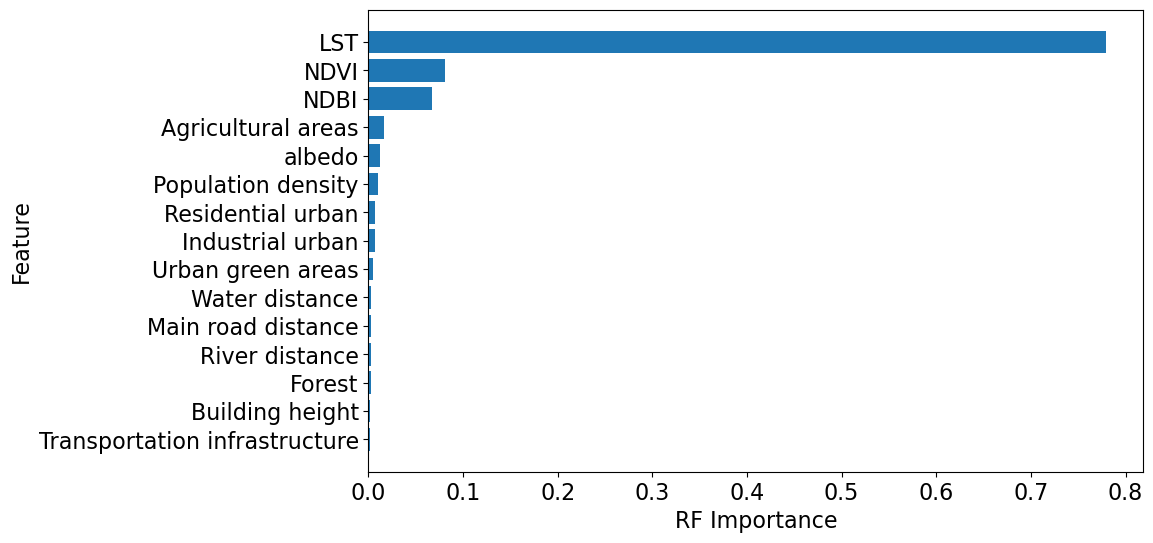

In [71]:
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 16})
# Plot
plt.figure(figsize=(10, 6))
plt.barh(list(reversed(importances['label'])),list(reversed(importances[0])))
'''
plt.xticks(rotation=45, ha="right")
plt.xlabel("Land Cover Class")
plt.ylabel("Total Area (km²)")
plt.title("Land Cover Change Across Different Datasets")
plt.legend(title="Dataset", bbox_to_anchor=(1, 1))
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
'''
plt.xlabel('RF Importance', fontsize=16)
plt.ylabel('Feature', fontsize=16)
plt.show()


In [58]:
str(score)[2:4] 

'84'

In [29]:
if train_model:
    #save model
    model_score = str(score)[2:4]
    model_file = f'model/model_{model}_{model_score}{sufix}.pkl'
    print(model_file)
    with open(model_file, 'wb') as file:
        pickle.dump(ai_model, file)

model/model_ANN_77_feb_14_100mil.pkl


# PREDICTION

In [30]:
if not train_model:
    #model_score = '85'
    # Load the trained model using pickle
    #model_file = f'model/model_{model}_86.pkl'
    with open(model_file, 'rb') as file:
        ai_model = pickle.load(file)

In [31]:
# predict the whole image
importer = processing.HarmoniaProcessor()

# get raster parameters from landcover
with rasterio.open(landcover_path, driver="GTiff") as base_raster:
    transform = base_raster.transform
    init_x = transform[2]
    init_y = transform[5]
    step_x = transform[0]
    step_y = transform[4]

#import samples
base_path = f'training_samples'
#sufix = '_DUSAF'
sufix = '_feb_14'
predict_path = f'{base_path}/{city}_predict{sufix}.csv'
predict = importer.import_df(predict_path, date_format=None)

predict['lst'] = predict['lst'].astype('float32')
predict['ndvi'] = predict['ndvi'].astype('float32')
predict['ndbi'] = predict['ndbi'].astype('float32')
predict['albedo'] = predict['albedo'].astype('float32')
predict['landcover'] = predict['landcover'].astype('int32')
predict['x'] = predict['x'].astype('float64')
predict['y'] = predict['y'].astype('float64')

predict['landcover'] = predict['landcover']#.apply(map_urban_atlas_class).astype('int32')

predict['x'] = predict['x'].apply(
    lambda x: init_x + (x * step_x)
)
predict['y'] = predict['y'].apply(
    lambda y: init_y + (y * step_y)
)

predict_x_positions = predict.x.values
predict_y_positions = predict.y.values

full_data_df = fetch_from_odc(
    odc_datasets, 
    predict,
    x=xr.DataArray(predict_x_positions, dims=['index']),
    y=xr.DataArray(predict_y_positions, dims=['index'])
)

#remove water pixels
full_data_df = full_data_df.loc[
    full_data_df['landcover'] != WATER
].reset_index(drop=True)
print("ready")

#remove nodata from odc datasets
for col in odc_datasets:
    full_data_df = full_data_df.loc[
        full_data_df[col] != 9999
    ].reset_index(drop=True)

full_data_df

Sampling building_height
63008537 63008537
Sampling densita_popolazione
Sampling main_road_distance
Sampling river_distance
Sampling water_distance
odc_df Ready!
ready


x            y  landcover         lst      ndvi      ndbi  \
0         495341.1148  5054280.992          6  309.989258  0.444257 -0.133687   
1         495346.1148  5054280.992          6  310.381836  0.672136 -0.257020   
2         495351.1148  5054280.992          6  310.381836  0.672136 -0.257020   
3         495321.1148  5054275.992          6  309.989258  0.444257 -0.133687   
4         495326.1148  5054275.992          6  309.989258  0.444257 -0.133687   
...               ...          ...        ...         ...       ...       ...   
61865261  537921.1148  5001000.992          5  311.829102  0.529260 -0.115972   
61865262  537926.1148  5001000.992          5  311.829102  0.529260 -0.115972   
61865263  537931.1148  5001000.992          5  311.829102  0.529260 -0.115972   
61865264  537936.1148  5001000.992          5  311.308105  0.568186 -0.153507   
61865265  537941.1148  5001000.992          5  311.308105  0.568186 -0.153507   

            albedo  building_height  densita_popolazione  main_road_distance  \
0         0.138582              0.0                  0.0         3550.003662   
1         0.123007              0.0                  0.0         3551.936035   
2         0.123007              0.0                  0.0         3553.874512   
3         0.138582              0.0                  0.0         3537.711182   
4         0.138582              0.0                  0.0         3539.622070   
...            ...              ...                  ...                 ...   
61865261  0.162138              0.0                  0.0            0.000000   
61865262  0.162138              0.0                  0.0            0.000000   
61865263  0.162138              0.0                  0.0            0.000000   
61865264  0.158356              0.0                  0.0            0.000000   
61865265  0.158356              0.0                  0.0            0.000000   

          river_distance  water_distance  
0             916.856079      916.856079  
1             920.570435      920.570435  
2             924.296997      924.296997  
3             898.721313      898.721313  
4             902.399597      902.399597  
...                  ...             ...  
61865261     2256.014160     2256.014160  
61865262     2252.026855     2252.026855  
61865263     2248.043457     2248.043457  
61865264     2244.064453     2244.064453  
61865265     2240.089355     2240.089355  

[61865266 rows x 12 columns]

In [ ]:
full_data_df.describe()

In [32]:
if encode:
    #encode categorical columns
    encoding_columns = ['landcover']
    all_encoded_columns = []
    for enc in encoding_columns:
        enc_list = full_data_df[enc].values.reshape(-1, 1)
        encoded_data = encoders[enc].transform(enc_list)

        encoded_columns = [f"{enc}_{category}" for category in encoders[enc].get_feature_names_out([enc])]
        print(encoded_columns)
        full_data_df = pd.concat([full_data_df, pd.DataFrame(encoded_data, columns=encoded_columns)], axis=1)
        all_encoded_columns += encoded_columns.copy()
        full_data_df = full_data_df.drop(columns=[enc])

    full_data_df = full_data_df.dropna()
    for enc_col in all_encoded_columns:
        full_data_df[enc_col] = full_data_df[enc_col].astype('uint16')

    #drop resulting _nan columns
    _nan_columns = list(filter(lambda x: '_nan' in x, list(full_data_df.columns)))
    full_data_df = full_data_df.drop(columns=_nan_columns)

full_data_df

['landcover_landcover_1', 'landcover_landcover_2', 'landcover_landcover_3', 'landcover_landcover_4', 'landcover_landcover_5', 'landcover_landcover_6']


x            y         lst      ndvi      ndbi    albedo  \
0         495341.1148  5054280.992  309.989258  0.444257 -0.133687  0.138582   
1         495346.1148  5054280.992  310.381836  0.672136 -0.257020  0.123007   
2         495351.1148  5054280.992  310.381836  0.672136 -0.257020  0.123007   
3         495321.1148  5054275.992  309.989258  0.444257 -0.133687  0.138582   
4         495326.1148  5054275.992  309.989258  0.444257 -0.133687  0.138582   
...               ...          ...         ...       ...       ...       ...   
61865261  537921.1148  5001000.992  311.829102  0.529260 -0.115972  0.162138   
61865262  537926.1148  5001000.992  311.829102  0.529260 -0.115972  0.162138   
61865263  537931.1148  5001000.992  311.829102  0.529260 -0.115972  0.162138   
61865264  537936.1148  5001000.992  311.308105  0.568186 -0.153507  0.158356   
61865265  537941.1148  5001000.992  311.308105  0.568186 -0.153507  0.158356   

          building_height  densita_popolazione  main_road_distance  \
0                     0.0                  0.0         3550.003662   
1                     0.0                  0.0         3551.936035   
2                     0.0                  0.0         3553.874512   
3                     0.0                  0.0         3537.711182   
4                     0.0                  0.0         3539.622070   
...                   ...                  ...                 ...   
61865261              0.0                  0.0            0.000000   
61865262              0.0                  0.0            0.000000   
61865263              0.0                  0.0            0.000000   
61865264              0.0                  0.0            0.000000   
61865265              0.0                  0.0            0.000000   

          river_distance  water_distance  landcover_landcover_1  \
0             916.856079      916.856079                      0   
1             920.570435      920.570435                      0   
2             924.296997      924.296997                      0   
3             898.721313      898.721313                      0   
4             902.399597      902.399597                      0   
...                  ...             ...                    ...   
61865261     2256.014160     2256.014160                      0   
61865262     2252.026855     2252.026855                      0   
61865263     2248.043457     2248.043457                      0   
61865264     2244.064453     2244.064453                      0   
61865265     2240.089355     2240.089355                      0   

          landcover_landcover_2  landcover_landcover_3  landcover_landcover_4  \
0                             0                      0                      0   
1                             0                      0                      0   
2                             0                      0                      0   
3                             0                      0                      0   
4                             0                      0                      0   
...                         ...                    ...                    ...   
61865261                      0                      0                      0   
61865262                      0                      0                      0   
61865263                      0                      0                      0   
61865264                      0                      0                      0   
61865265                      0                      0                      0   

          landcover_landcover_5  landcover_landcover_6  
0                             0                      1  
1                             0                      1  
2                             0                      1  
3                             0                      1  
4                             0                      1  
...                         ...                    ...  
61865261                      1          

In [33]:
#Convert all odc dataset columns to float32 to save disk
for col in odc_datasets:
    full_data_df[col] = full_data_df[col].astype('float32')

full_data_df

x            y         lst      ndvi      ndbi    albedo  \
0         495341.1148  5054280.992  309.989258  0.444257 -0.133687  0.138582   
1         495346.1148  5054280.992  310.381836  0.672136 -0.257020  0.123007   
2         495351.1148  5054280.992  310.381836  0.672136 -0.257020  0.123007   
3         495321.1148  5054275.992  309.989258  0.444257 -0.133687  0.138582   
4         495326.1148  5054275.992  309.989258  0.444257 -0.133687  0.138582   
...               ...          ...         ...       ...       ...       ...   
61865261  537921.1148  5001000.992  311.829102  0.529260 -0.115972  0.162138   
61865262  537926.1148  5001000.992  311.829102  0.529260 -0.115972  0.162138   
61865263  537931.1148  5001000.992  311.829102  0.529260 -0.115972  0.162138   
61865264  537936.1148  5001000.992  311.308105  0.568186 -0.153507  0.158356   
61865265  537941.1148  5001000.992  311.308105  0.568186 -0.153507  0.158356   

          building_height  densita_popolazione  main_road_distance  \
0                     0.0                  0.0         3550.003662   
1                     0.0                  0.0         3551.936035   
2                     0.0                  0.0         3553.874512   
3                     0.0                  0.0         3537.711182   
4                     0.0                  0.0         3539.622070   
...                   ...                  ...                 ...   
61865261              0.0                  0.0            0.000000   
61865262              0.0                  0.0            0.000000   
61865263              0.0                  0.0            0.000000   
61865264              0.0                  0.0            0.000000   
61865265              0.0                  0.0            0.000000   

          river_distance  water_distance  landcover_landcover_1  \
0             916.856079      916.856079                      0   
1             920.570435      920.570435                      0   
2             924.296997      924.296997                      0   
3             898.721313      898.721313                      0   
4             902.399597      902.399597                      0   
...                  ...             ...                    ...   
61865261     2256.014160     2256.014160                      0   
61865262     2252.026855     2252.026855                      0   
61865263     2248.043457     2248.043457                      0   
61865264     2244.064453     2244.064453                      0   
61865265     2240.089355     2240.089355                      0   

          landcover_landcover_2  landcover_landcover_3  landcover_landcover_4  \
0                             0                      0                      0   
1                             0                      0                      0   
2                             0                      0                      0   
3                             0                      0                      0   
4                             0                      0                      0   
...                         ...                    ...                    ...   
61865261                      0                      0                      0   
61865262                      0                      0                      0   
61865263                      0                      0                      0   
61865264                      0                      0                      0   
61865265                      0                      0                      0   

          landcover_landcover_5  landcover_landcover_6  
0                             0                      1  
1                             0                      1  
2                             0                      1  
3                             0                      1  
4                             0                      1  
...                         ...                    ...  
61865261                      1          

In [34]:
columns = ['ndvi', 'albedo', 'lst', 'building_height', 'densita_popolazione',
       'main_road_distance', 'river_distance', 'water_distance',
       'landcover_landcover_1', 'landcover_landcover_2',
       'landcover_landcover_3', 'landcover_landcover_4',
       'landcover_landcover_5', 'landcover_landcover_6']

In [ ]:
predict_df = full_data_df.copy()

data_coord = pd.concat([predict_df[col] for col in ['y', 'x']], axis=1)
predict_df = predict_df.drop(columns=['x','y'])

#Fix order column for model
column_order = ["ndvi","albedo","lst"]
column_order += odc_datasets
column_order += ["landcover_landcover_1","landcover_landcover_2","landcover_landcover_3","landcover_landcover_4","landcover_landcover_5","landcover_landcover_6"]

predict_df = predict_df[column_order]

# ignore the warnings for feature names. The important thing is that the dataset has the same order of the training one
# to remove the warnings create a dataframe with the normalized dataset and the column list
batch_size = 1000000

if normalize:
    full_data_predict = scaler.transform(predict_df)
else:
    full_data_predict = predict_df

# predict probabilities in batches
probs = []
for i in range(0, len(full_data_predict), batch_size):
    batch = full_data_predict[i:i+batch_size]
    batch_probs = ai_model.predict_proba(batch)[:,1]
    probs.append(batch_probs)
    print(f'Done {i}')

full_data_prob = np.concatenate(probs, axis=0)
full_data_prob


In [ ]:
#append the x,y coordinates to the probabilities
full_data_df = pd.DataFrame(full_data_prob).reset_index(drop=True)
full_data_df['x'] = data_coord['x'].reset_index(drop=True)
full_data_df['y'] = data_coord['y'].reset_index(drop=True)

In [ ]:
full_data_df.rename(columns={0:'probability'}, inplace=True)
full_data_df = full_data_df.round({'probability': 4})
full_data_df['probability'] = full_data_df['probability'].astype('float32')


In [ ]:
base_path = 'predictions'
predictions_path = f'{base_path}/{city}_UHI_{model}_predictions_acc_{model_score}{sufix}_100mil.csv'
print(f'Saving to {predictions_path}')
full_data_df.to_csv(predictions_path)
